# K-neighbors: Wine dataset
[UCI Machine learning](https://archive.ics.uci.edu/dataset/109/wine)
## Codice di esecuzione
### Caricamento dati

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from src.utils import *


df = load_wine_data()


### Exploratory Data Analysis
#### Scaling delle features

Lo scaling è per fare una valutazione di come variano i dati, dovrà essere eseguito nuovamente prima di eseguire l'algoritmo: si scala solamente x_test, in quanto a x_train si applicheranno i parametri di normalizzazione di x_test (la normalizzazione sull'intero dataset mostra all'algoritmo informazioni che inficiano sull'analisi)

In [2]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[df.columns.difference(["Class"])] = scaler.fit_transform(df[df.columns.difference(["Class"])])        # Difference esclude Class (che ovviamente non va normalizzata), ma la ritorna nel df di destinazione !!!!! BEI CAZZI !!!!!

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
df_scaledRR = df.copy()
df_scaledRR[df.columns.difference(["Class"])] = scaler.fit_transform(df[df.columns.difference(["Class"])])        # Difference esclude Class (che ovviamente non va normalizzata), ma la ritorna nel df di destinazione !!!!! BEI CAZZI !!!!!

#### Chart

In [ ]:
df.describe()
print(df.Class.value_counts())

eda_chart_heat_pair(df)                                 # Heatmap e pairplot    

eda_chart_box_preprocessed(df)                          # Boxplot prima della normalizzazione (divide in due file)      
eda_chart_box_scaled(df_scaled, "StandardScaled")       # Boxplot dopo la StardardScaler
eda_chart_box_scaled(df_scaledRR, "RobustdScale")       # Boxplot dopo la RobustScaler


Class
2    71
1    59
3    48
Name: count, dtype: int64


- Il conteggio delle classi non è proporzionale.
- Ho creato una versione di pairplot con evidenziazioni

#### PCA

In [ ]:
pca_plot(df, "preScaled")
pca_plot(df_scaled, "StandardScaled")
pca_plot(df_scaledRR, "RobustdScale")

[0.99809123 0.99982715]
[0.36198848 0.55406338]
[0.32853032 0.52534437]


- **PCA Standard Scaler**  importante migliroamento della distinzione tra le classi. La PCA si basa ora sulle relazioni tra variabili (non sui valori assoluti)
- **PCA Robust Scaler**    robust scaler si utilizza se gli outlier distorgono le informazioni. Non sembra apportare miglioramenti rispetto a Standard Scaler


cosa cazzo sono i valori che stampo ?

### K-Neighbor

Miglior valore di K: 18


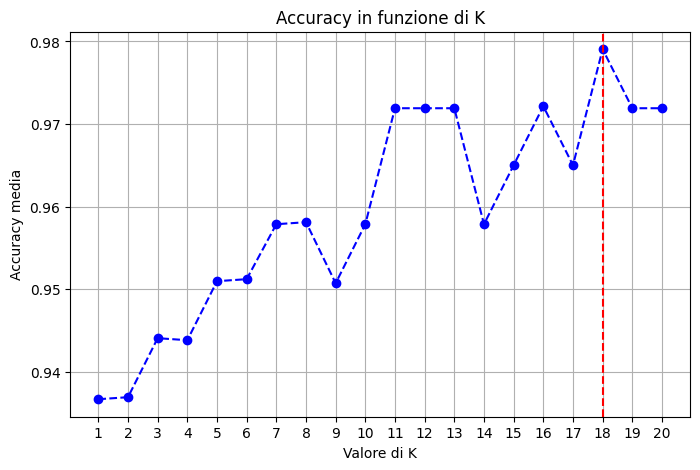

In [ ]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

# DIVISIONE TRAIN TEST
from sklearn.model_selection import train_test_split, GridSearchCV
X_train, X_test, y_train, y_test  = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y)

# NORMALIZZAZIONE
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_ss = scaler.fit_transform(X_train)      
X_test_ss = scaler.transform(X_test)        



# TEST SU UN RANGE DI K PER VALUTARE IL K OTTIMALE
from sklearn.neighbors import KNeighborsClassifier
param_grid = {'n_neighbors': np.arange(1, 21)}                                              # Definisce il range di K da testare
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')    # Esegue la ricerca con validazione incrociata
grid_search.fit(X_train_ss, y_train)                                                        # Addestra il modello con tutti i valori di K
best_k = grid_search.best_params_['n_neighbors']                                            # Ottiene il valore di K ottimale
print(f'Miglior valore di K: {best_k}')                                                     # Stampa il miglior valore di K

# PLOT ACCURACY PER K
k_values = np.arange(1, 21)
accuracies = grid_search.cv_results_['mean_test_score']
plt.figure(figsize=(8,5))
plt.plot(k_values, accuracies, marker='o', linestyle='dashed', color='b')
plt.axvline(x=best_k, color='r', linestyle='--', label=f'Best K: {best_k}')
plt.xlabel('Valore di K')
plt.ylabel('Accuracy media')
plt.title('Accuracy in funzione di K')
plt.xticks(k_values)
plt.grid()
plt.show()



In [ ]:
from sklearn.metrics import accuracy_score  # Per calcolare l'accuratezza del modello

# ADDESTRO IL MODELLO CON IL MIGLIOR K
knn = KNeighborsClassifier(n_neighbors=2)               # Inizializza il modello con il miglior K
knn.fit(X_train_ss, y_train)                            # Addestra il modello
y_pred = knn.predict(X_test_ss)                         # Effettua la previsione sui dati di test


Accuratezza sul test set: 0.94
              precision    recall  f1-score   support

           1       0.86      1.00      0.92        12
           2       1.00      0.86      0.92        14
           3       1.00      1.00      1.00        10

    accuracy                           0.94        36
   macro avg       0.95      0.95      0.95        36
weighted avg       0.95      0.94      0.94        36

[[12  0  0]
 [ 2 12  0]
 [ 0  0 10]]


Se forzo n_neighborn a 2 ottengo accuratezza di 0.94, mentre nel grafico è inferiore. Nel gridsearch sto utilizzando la cross validation

              precision    recall  f1-score   support

           1       0.86      1.00      0.92        12
           2       1.00      0.86      0.92        14
           3       1.00      1.00      1.00        10

    accuracy                           0.94        36
   macro avg       0.95      0.95      0.95        36
weighted avg       0.95      0.94      0.94        36



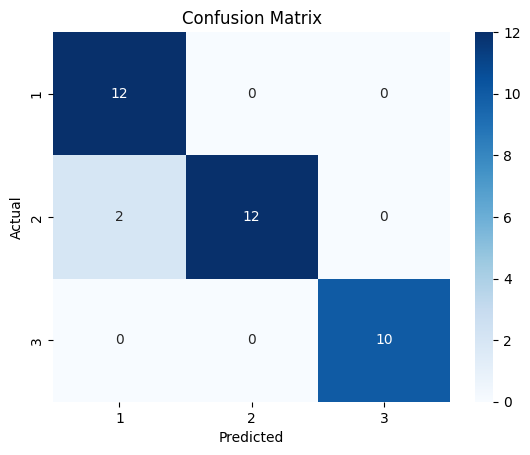

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
# Report (Precision e Recall per ogni classe)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3], yticklabels=[1, 2, 3])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


#### Commento allo scoring
- **Accuracy** misura la percentuale di previsioni corrette
    - Se il dataset è sbilanciato potrebbe essere fuorviante
- **Precisione** misura quante delle previsioni positive fatte dal modello erano corrette
    - Alta precisione significa pochi falsi positivi
- **Recall** misura quanti errori della classe positiva sono stati correttamente trovati
    - Alto recall significa che il modello trova quasi tutti i positivi
- **F1 score** Media armonica tra precisione e recall
    - Utile quando le classi sono sbilanciate

In [ ]:
classification_report(y_test, y_pred)

'              precision    recall  f1-score   support\n\n           1       0.86      1.00      0.92        12\n           2       1.00      0.86      0.92        14\n           3       1.00      1.00      1.00        10\n\n    accuracy                           0.94        36\n   macro avg       0.95      0.95      0.95        36\nweighted avg       0.95      0.94      0.94        36\n'

#### Commento all'analisi esploratoria


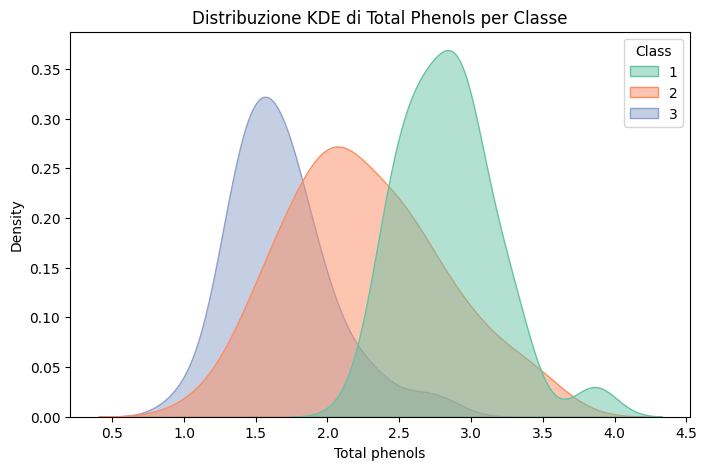

In [ ]:
plt.figure(figsize=(8, 5))
sns.kdeplot(data=df, x="Total phenols", hue="Class", fill=True, palette="Set2", alpha=0.5)
plt.title("Distribuzione KDE di Total Phenols per Classe")
plt.show()

C:\Users\enric\AppData\Local\Temp\ipykernel_5864\881004350.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Class", y="Total phenols", palette="Set2")


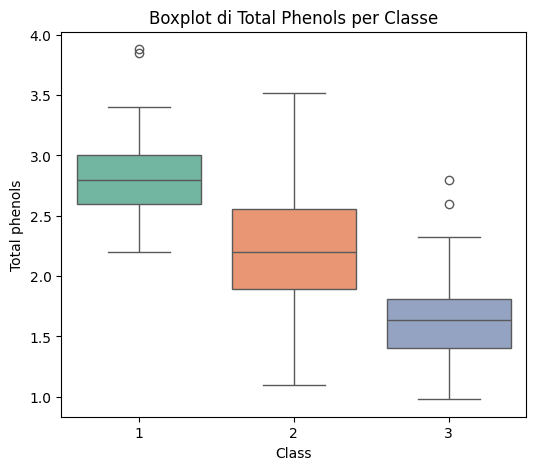

In [ ]:
plt.figure(figsize=(6, 5))
sns.boxplot(data=df, x="Class", y="Total phenols", palette="Set2")
plt.title("Boxplot di Total Phenols per Classe")
plt.show()

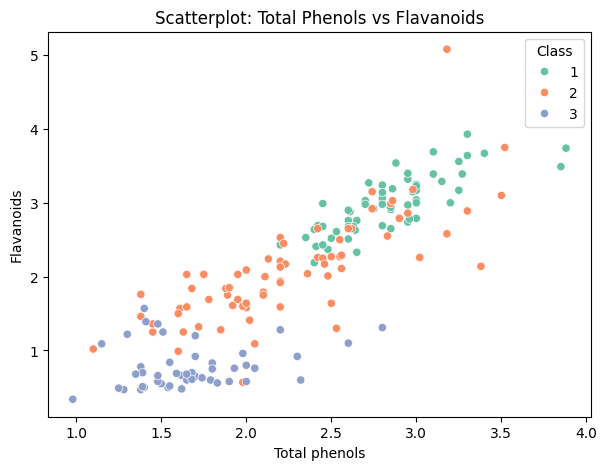

In [ ]:
plt.figure(figsize=(7, 5))
sns.scatterplot(data=df, x="Total phenols", y="Flavanoids", hue="Class", palette="Set2")
plt.title("Scatterplot: Total Phenols vs Flavanoids")
plt.show()


## 🔍 Verifica delle tue osservazioni

### 1️⃣ KDE Plot  
✔️ La curva della classe 2 è sovrapposta a 1 e 3 → quindi *Total Phenols*, da solo, non è un forte separatore per la classe 2.  

### 2️⃣ Boxplot  
✔️ La mediana della classe 2 è ben distinta, ma gli outlier di 1 e 3 disturbano la distribuzione globale.  
✔️ Questo significa che la classe 2 è **centrale**, ma con una **sovrapposizione alle altre due**.  

### 3️⃣ Scatterplot con Flavanoids  
✔️ Classe 1 e 3 sono **ben separate**, ma la classe 2 si sovrappone molto alla 3.  

---

## 🔥 Conclusione sulla Classe 2 e *Total Phenols*  

- *Total Phenols* **non è un forte separatore per la classe 2**, anche se distingue bene **1 da 3**.  
- **Possibile soluzione** → Verificare **altri scatterplot** con feature diverse per separare meglio la classe 2.  
- **Alternative:**  
  - Testare una combinazione con altre feature (*Total Phenols + Hue?*).  
  - Provare **PCA** per vedere se una combinazione lineare delle feature aiuta.  

---

🚀 **Vuoi esplorare un’altra combinazione di feature per la classe 2 o passiamo avanti?**  


Se le prime 2 componenti catturano meno dell’80% della varianza, potremmo aver bisogno di più componenti.

e le prime due componenti spiegano già il 99% della varianza, significa che quasi tutte le informazioni del dataset sono condensate in queste due dimensioni.

📌 Cosa implica questo valore alto?
✔️ Non serve aggiungere altre componenti, perché quasi tutta l'informazione è già nelle prime due.
✔️ La sovrapposizione tra classe 2 e 3 è reale, non è un limite della PCA → Significa che nel dataset originale queste due classi non sono chiaramente separabili con le feature a disposizione.

Voglio differenziare maggiormente 2 e 3, provo robustscaler

#### Box-plot
Rimossi "Magnesium", "Proline", "Alcalinity of ash" perchè fuori scala, sarà interessante rielaborare grafico dopo lo scaling. Vanno comunque graficate

Le features più interessanti potrebbero essere
- Total phenols
- Flavanoids
- Alcohol

#### Pairplot
Impariamo a leggere il pairplot.
Sulla diagonale KDE Plot (Kernel Density Plot). L'asse delle y non rappresenta la frequenza assoluta ma una stima delle probabilità che un valore appartenga a quella classe.


#### Appunti
- Alcohol
    - Classe 1 e 2 ben separate, la classe 3 si sovrappone alle altre due sugli estremi. Features interessante per separare 1vs2.
    - Correlazione moderata con Color intensity     0.55
    - Correlazione moderatamente forte con proline  0.64
- Malic Acid
    - No forte distinzione tra le classi
    - Classe 3 ha valori tendenzialmente più alti ma gli outlier delle altre due classi potrebbero sporcare la distinzione
    - Correlazione moderata inversa con hue -0.55
- Ash
    - Classi sovrapposte
    - Nessuna correlazione
- Flavanoids
    Classe 1 e 3 ben separate, la classe 2 si sovrappone alle altre due sugli estremi. Features interessante per separare 1vs3.

A questo punto mi pare di starmi facendo una serie di seghe non indifferenti.

Tentiamo una normalizzazione delle features e valutiamo nuovamente l'analisi




##### Analisi delle Feature

| Feature            | Separazione tra Classi | Correlazioni | Osservazioni |
|--------------------|----------------------|--------------|--------------|
| Alcohol           | 1 e 2 ben separate, 3 si sovrappone agli estremi | Moderata con Color Intensity (0.55), Moderatamente forte con Proline (0.64) | Utile per separare 1 vs 2 |
| Malic Acid        | Nessuna distinzione forte, classe 3 tendenzialmente più alta | Moderata inversa con Hue (-0.55) | Possibili problemi con outlier |
| Ash               | Classi sovrapposte | Nessuna forte correlazione | Probabilmente poco utile |
| Alcalinity of Ash | Nessuna forte distinzione, ma tende a salire (1 vs 3) | - | Potrebbe aiutare in combinazione con altre feature |
| Magnesium         | Classi non ben definite | - | Probabilmente poco utile |
| Proline          | Classe 1 ben distinta dalle altre | Moderatamente forte con Alcohol (0.64) | Potenzialmente utile per distinguere classe 1 |


#####
#### Effetti della Normalizzazione sui Grafici

LA NORMALIZZAZIONE TI CAMBIA SOLO LA SCALA DEI VALORI, RAPPORTI E DISTANZE RIMANGONO I MEDESIMI

### 1️⃣ Boxplot  
✔️ Il boxplot è cambiato perché la scala dei valori è stata trasformata → Ora tutte le feature hanno media 0 e deviazione standard 1.  

### 2️⃣ Pairplot e Matrice di Correlazione  
✔️ Il pairplot e la matrice di correlazione sono rimasti invariati perché:  

- **Pairplot** → Le relazioni tra le feature non cambiano con la normalizzazione, solo i valori assoluti.  
- **Correlazione** → La correlazione è invariante rispetto alla scala → StandardScaler non cambia i rapporti tra le variabili, quindi la matrice di correlazione è la stessa.  

